# Logistic Regression Using Scikit-Learn

## The Model
A logistic regression model (often called a logit model or a log-linear classifier) is a linear classification model. It is called the logistic regression because of its use of the logistic function (also known as the sigmoid function),
$$\Phi(z) = \frac{1}{1+e^{-z}},$$
which has the following graph:

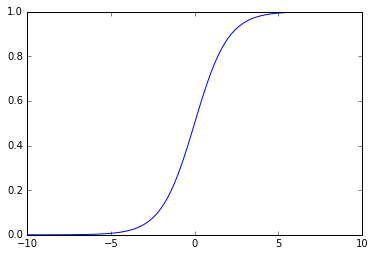

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def logistic(z):
    return 1./(1+np.exp(-z))

z = np.linspace(-10, 10, 101)
plt.plot(z, logistic(z))
plt.show()

As we can see, the logistic function is bound below by $0$ and above by $1$. In fact it is the shape of a distribution function.  

The logistic regression model then consists of weights $W \in \mathbb{R}^{n+1}$ optimally chosen by training the model (usually through maximum likelihood estimation) such that for random variables $Y \in \{0,1\}$ and $X \in \{1\} \times \mathbb{R}^{n}$ we have 
$$P(Y=1|X) = \Phi(W^TX).$$  

To make this clearer lets look at an example.

## An Example

This will use the Titanic dataset found at http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets/titanic3.csv. An explanation of the variables in the dataset can be found at http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/Ctitanic3.html.  

The data lists all the passengers on the Titanic, certain features about them (like age, gender, and the class of their ticket), and whether they survived the shipwreck or not. We wish to use this data to create a logistic model that accurately predicts the probability of a passenger with a given set of features surviving the Titanic.  

So, using the notation from above we have $X = (1, feature_1, feature_2, ... , feature_n)$, $Y = 
   \begin{cases} 
      1 & \text{if the passenger survived} \\
      0 & \text{if the passenger did not survived}
   \end{cases}$, and $\hat{W}=(w_0, w_1, w_2, ... w_n)$ is to be determined.


In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

In [9]:
# Read in the data.
f = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv'
data = pd.read_csv(f)
# Drop the variables that we aren't going to use for this example.
data = data.drop(['name','ticket','fare','cabin','embarked',
                  'boat','body','home.dest'],1)
# Drop observations that are missing data.
data = data.dropna()

In [10]:
data.head(10)

,pclass,survived,sex,age,sibsp,parch
0,1,1,female,29.00,0,0
1,1,1,male,0.92,1,2
2,1,0,female,2.00,1,2
3,1,0,male,30.00,1,2
4,1,0,female,25.00,1,2
5,1,1,male,48.00,0,0
6,1,1,female,63.00,1,0
7,1,0,male,39.00,0,0
8,1,1,female,53.00,2,0
9,1,0,male,71.00,0,0


In [11]:
# Change the 'sex' column to be a binary variable with 1 for female
# and 0 for male.
data = data.replace(['female', 'male'], [1, 0])
# Create binary variables indicating first class and second class.
data['pclass1'] = (data['pclass']==1).astype(int)
data['pclass2'] = (data['pclass']==2).astype(int)

In [12]:
data.head(10)

,pclass,survived,sex,age,sibsp,parch,pclass1,pclass2
0,1,1,1,29.00,0,0,1,0
1,1,1,0,0.92,1,2,1,0
2,1,0,1,2.00,1,2,1,0
3,1,0,0,30.00,1,2,1,0
4,1,0,1,25.00,1,2,1,0
5,1,1,0,48.00,0,0,1,0
6,1,1,1,63.00,1,0,1,0
7,1,0,0,39.00,0,0,1,0
8,1,1,1,53.00,2,0,1,0
9,1,0,0,71.00,0,0,1,0


In [13]:
X = data[['sex', 'age', 'sibsp', 'parch', 'pclass1', 'pclass2']]
Y = data['survived']

# Separate the data into a training dataset and a testing dataset.
# We make the model using the training set and will use the testing
# set to test the model's predictive power.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=100)

# We use the scikit-learn LogisticRegression object to train the model.
LR = LogisticRegression()
LR.fit(X_train, Y_train)

# We get the following weights.
print 'Weights:', np.r_[LR.intercept_, LR.coef_[0]]


Weights: [-0.84362458  2.40734928 -0.04195199 -0.35754211  0.06716351  2.17872145
  0.90809101]


## Evaluating the Performance of Our Model

To evaluate the predictive power of our model, we will test it on the test set, the data that it wasn't trained on, and then see how many false positive and false negatives we get. Of course, our model gives the probability that someone with given features survives, so we need to set a threshold $\tau$ such that if $P(Y=1|X)>\tau$ we say this person survived. From this we can find the false positive rate and true positive rate as functions of $\tau$. Graphing these rates give what is called a Receiver Operating Characteric (ROC) curve. Intuitively, we want the area under this curve to be as close to 1 as possible, thus we sometimes use the metric Area Under the Curve (AUC) as a measure of how good our model is. 

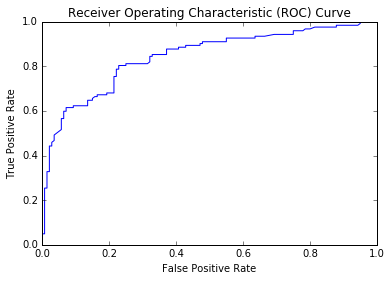

AUC: 0.842974238876


In [14]:
# Derive the probability of survival for each sample in the test set.
probs = LR.predict_proba(X_test)
# Derive the false pos rate and true pos rate.
fpr, tpr, thresh = roc_curve(Y_test, probs[:,1], pos_label=1)
# Graph the ROC curve.
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
# Calculate the AUC.
print 'AUC:', auc(fpr, tpr)

Just for fun lets change some of the features in the model and see what the difference is.

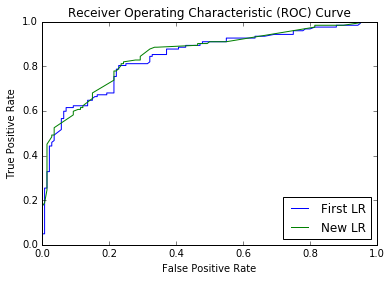

First AUC: 0.842974238876
Second AUC: 0.85181498829


In [15]:
data['family'] = data['sibsp']+data['parch']
data['child'] = (data['age']<10).astype(int)
data['old'] = (data['age']>40).astype(int)

X = data[['sex', 'child', 'old', 'sibsp', 'parch', 'pclass1', 'pclass2']]
Y = data['survived']

# Separate the data into a training dataset and a testing dataset. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=100)

# We use the scikit-learn LogisticRegression object to train the model.
LR = LogisticRegression()
LR.fit(X_train, Y_train)
probs = LR.predict_proba(X_test)

fpr2, tpr2, thresh2 = roc_curve(Y_test, probs[:,1], pos_label=1)
plt.plot(fpr, tpr, label='First LR')
plt.plot(fpr2, tpr2, label='New LR')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()
print 'First AUC:', auc(fpr, tpr)
print 'Second AUC:', auc(fpr2, tpr2)

Maybe there is a slight improvement...